### 함수정리

In [1]:
def to_datetime(timestamp) :
    return datetime.fromtimestamp(timestamp/1000)

def to_timestamp(date) :
    tmp = datetime.strptime(date, '%Y-%m-%d')
    return int((str(time.mktime(tmp.timetuple()))[:-2] + '000'))

def crawle_data(symbol, crawl_start_date) :
    
    try : 
        starting = time.time()

        ep='https://api.binance.com'
        candle = '/api/v3/klines'

        start_date = []
        start_time = []
        openn = []
        high = []
        low = []
        close = []
        volume = []

        start = to_timestamp(crawl_start_date)
        first_params_candle = {'symbol': symbol, 'interval' : '1m','startTime' : start , 'limit' : 1 } # 초기세팅
        r1 = requests.get(ep+candle, params=first_params_candle )

        while len(r1.json()) > 0 :
            first_params_candle = {'symbol': symbol, 'interval' : '1m','startTime' : start , 'limit' : 1000 }
            r1 = requests.get(ep+candle, params=first_params_candle ) #use parameter
            req = r1.json()
            for i in range(0,len(req)) : 
                start_date.append(datetime.fromtimestamp(req[i][0]/1000).strftime('%Y%m%d'))
                start_time.append(datetime.fromtimestamp(req[i][0]/1000).strftime('%H%M'))
                close.append(req[i][4])
            if len(req) > 0 : # 받아온 데이터가 있을 경우 => 다음 루프 시작
                start = req[-1][6]+1
            else : print(symbol + " 다운로드 완료")
            #time.sleep(0.25) # 횟수제한을 위해 추가

        ticker = [symbol] * len(start_date)

        chartData = {'date': start_date, 'time': start_time, 'ticker': ticker, 'close': close}

        df = pd.DataFrame(chartData, columns=['date', 'time', 'ticker', 'close'])
        df2 = df[['date', 'time', 'close']]
        df2.columns = ['date', 'time', symbol]

        print("소요 시간 : ", time.time() - starting)
        
        return df2
    
    # 데이터 안불러 와지는 경우 keyerror가 나므로 예외처리함
    except KeyError as e :
        print(e)

In [2]:
def update_crawl(symbol, crawl_start_date) :
    
    try : 
        starting = time.time()

        ep='https://api.binance.com'
        candle = '/api/v3/klines'

        start_date = []
        start_time = []
        openn = []
        high = []
        low = []
        close = []
        volume = []
        #future_close.index[-1].timestamp() * 1000
        #int(str(future_close.index[-1].timestamp() * 1000)[:-2])
        #math.floor(time.mktime(future_close.index[-1].timetuple()) * 1000)
        start = math.floor(time.mktime(crawl_start_date.timetuple()) * 1000)
        first_params_candle = {'symbol': symbol, 'interval' : '1m','startTime' : start , 'limit' : 1 } # 초기세팅
        r1 = requests.get(ep+candle, params=first_params_candle )

        while len(r1.json()) > 0 :
            first_params_candle = {'symbol': symbol, 'interval' : '1m','startTime' : start , 'limit' : 1000 }
            r1 = requests.get(ep+candle, params=first_params_candle ) #use parameter
            req = r1.json()
            for i in range(0,len(req)) : 
                start_date.append(datetime.fromtimestamp(req[i][0]/1000).strftime('%Y%m%d'))
                start_time.append(datetime.fromtimestamp(req[i][0]/1000).strftime('%H%M'))
                close.append(req[i][4])
            if len(req) > 0 : # 받아온 데이터가 있을 경우 => 다음 루프 시작
                start = req[-1][6]+1
            else : print(symbol + " 다운로드 완료")
            #time.sleep(0.25) # 횟수제한을 위해 추가

        ticker = [symbol] * len(start_date)

        chartData = {'date': start_date, 'time': start_time, 'ticker': ticker, 'close': close}

        df = pd.DataFrame(chartData, columns=['date', 'time', 'ticker', 'close'])
        df2 = df[['date', 'time', 'close']]
        df2.columns = ['date', 'time', symbol]

        print("소요 시간 : ", time.time() - starting)
        
        return df2
    
    # 데이터 안불러 와지는 경우 keyerror가 나므로 예외처리함
    except KeyError as e :
        print(e)

In [3]:
def cal_corr_num(corr_df, corr_list) :
    corr_num = []
    for corr in corr_list :
        tmp = []
        for i in range(len(corr_df.index)) :    
            tmp.append(len(corr_df.index[(corr_df.iloc[:, i] > corr)]))
        corr_num.append(sum(tmp))
    return corr_num

In [4]:
def cal_corr_name(corr_df) :
    corr_name = corr_df.stack().reset_index()
    corr_name = corr_name[corr_name[0] > 0.9]
    corr_name['name'] = corr_name['level_0'] + '-' + corr_name['level_1']
    corr_name.columns = ['pair_1', 'pair_2', 'corr', 'pair']
    corr_name.sort_values('corr', ascending = False, inplace = True)
    corr_name = corr_name.reset_index()
    corr_name = corr_name.iloc[:,1:]
    return corr_name

In [5]:
def calcul_alpha_beta(x, y) :
    ols_result = sm.OLS(y, x).fit()
    beta = ols_result.params.tolist()[0]
    return beta

In [6]:
def cal_gamma_pvalue(x, y) :
    beta = calcul_alpha_beta(x, y)
    residual = y - beta * x
    z_residual = stats.zscore(residual)

    y2 = residual.diff().shift(-1)[:-1]
    x2 = residual[:-1]
    gamma = calcul_alpha_beta(x2, y2)
    adf_result = adfuller(residual)
    p_value = adf_result[1]
    
    return (gamma, p_value, residual, beta)

In [7]:
def cal_g_p_list(corr_name_df, formation_log, option) :
    option_list = []
    for i in range(len(corr_name_df)) : 
        pair_1_name = corr_name_df['pair_1'][i]
        pair_2_name = corr_name_df['pair_2'][i]
        
        y = formation_log[pair_1_name]
        x = formation_log[pair_2_name]
        
        if option == 'gamma' :
            option_list.append(cal_gamma_pvalue(x,y)[0])
        if option == 'pvalue' :
            option_list.append(cal_gamma_pvalue(x,y)[1])
    return option_list

In [8]:
def get_corr_upper(df) : 
    corr = df.corr()
    future_list = df.columns.tolist()

    # 상부삼각행렬만 남김
    corr_upper = np.triu(corr)

    # 대각행렬 0으로 바꿈
    corr_upper[np.diag_indices_from(corr_upper)] = 0

    corr_upper_0 = pd.DataFrame(corr_upper)
    corr_upper_0.columns = future_list
    corr_upper_0.index = future_list
    return corr_upper_0

In [9]:
def get_low_p_pair(pair_num, resample, start, end) :
    formation_data = future_close.resample('{}T'.format(resample)).last()[start:end].dropna(how='all')
    formation_log = formation_data.applymap(lambda x: np.log(x))

    corr_upper_0 = get_corr_upper(formation_data)

    # correlation별 pair 갯수
    corr_list = [0.99, 0.98, 0.97, 0.96, 0.95, 0.94, 0.93, 0.92, 0.91, 0.9]
    cal_corr_num(corr_upper_0, corr_list)
    corr_name_df = cal_corr_name(corr_upper_0)
    pair_pvalue_gamma = corr_name_df.copy()
    pair_pvalue_gamma['p'] = cal_g_p_list(corr_name_df, formation_log, 'pvalue')
    pair_pvalue_gamma['gamma'] = cal_g_p_list(corr_name_df, formation_log, 'gamma')
    pair_pvalue_gamma['abs_gamma'] = pair_pvalue_gamma['gamma'].map(lambda x : abs(x))
    pair_pvalue_gamma['h_mean'] = pair_pvalue_gamma[['p','abs_gamma']].apply(stats.hmean, axis =1)
    
    print(pair_pvalue_gamma.sort_values(by = 'p').head(10))
    
    pair_p = pair_pvalue_gamma.sort_values(by = 'p')
    pair_p.reset_index(inplace = True)
    pair_p = pair_p.iloc[:,1:]

    selected_pair = pair_p['pair'][:pair_num].tolist()
    
    return selected_pair

In [10]:
def get_signal(future_close, start_date, median_date, end_date, pair_1, pair_2) :
    all_date = future_close[start_date:end_date].resample('1d').last().index.tolist()
    all_date = list(map(lambda x : datetime.strftime(x, '%Y-%m-%d %H:%M:%S')[:10], all_date))

    tmp_date = future_close[median_date:end_date].resample('1d').last().index.tolist()
    tmp_date = list(map(lambda x : datetime.strftime(x, '%Y-%m-%d %H:%M:%S')[:10], tmp_date))

    all_log = future_log[pair_1][start_date:end_date].resample('5T').last().dropna()
    all_log2 = future_log[pair_2][start_date:end_date].resample('5T').last().dropna()

    mean_list = []
    std_list = [] 

    tmp_log = future_log[pair_1][median_date:end_date].resample('5T').last().dropna()
    tmp_log2 = future_log[pair_2][median_date:end_date].resample('5T').last().dropna()

    beta = calcul_alpha_beta(tmp_log, tmp_log2)
    
    # residual 7일 구하기
    residual_all = all_log - beta * all_log2 

    # residual 당일 구하기
    pair_1_close = future_log[pair_1][t_date]
    pair_2_close = future_log[pair_2][t_date]
    residual_today = pair_1_close - beta * pair_2_close

    # residual 3일 구하기
    residual_insample = pd.Series()
    for date in tmp_date :
        pair_1_close = future_log[pair_1][date].resample('5T').last()
        pair_2_close = future_log[pair_2][date].resample('5T').last()

        residual =  pair_1_close - beta * pair_2_close
        residual_insample = pd.concat([residual_insample, residual])

        mean_list.append(residual.mean())
        std_list.append(residual.std(ddof=1))

    # 3일간의 resdiual daily 평균, 표준편차를 z-score 만드는 데 활용
    mean_ave = sum(mean_list) / len(mean_list)
    std_ave  = sum(std_list)  / len(std_list)

    all_sample_zscore = (residual_all - mean_ave)      / std_ave
    in_sample_zscore =  (residual_insample - mean_ave) / std_ave
    out_sample_zscore = (residual_today - mean_ave)    / std_ave

    # 당일 signal
    signal_df = pd.DataFrame()
    signal_df['signal'] = out_sample_zscore
    signal_df['+open'] = 2
    signal_df['-open'] = -2
    signal_df['+close'] = 0.3
    signal_df['-close'] = -0.3
    signal_df['Date'] = out_sample_zscore.index.tolist()
    signal_df.set_index('Date', inplace =True)
    
    # 3일전부터의 signal
    in_sample_signal_df = pd.DataFrame()
    in_sample_signal_df['signal'] = pd.concat([in_sample_zscore, out_sample_zscore]).tolist()
    in_sample_signal_df['+open'] = 2
    in_sample_signal_df['-open'] = -2
    in_sample_signal_df['+close'] = 0.3
    in_sample_signal_df['-close'] = -0.3
    in_sample_signal_df['Date'] = pd.concat([in_sample_zscore, out_sample_zscore]).index.tolist()
    in_sample_signal_df.set_index('Date', inplace =True)

    # 7일전부터의 signal
    all_sample_signal_df = pd.DataFrame()
    all_sample_signal_df['signal'] = pd.concat([all_sample_zscore, out_sample_zscore]).tolist()
    all_sample_signal_df['+open'] = 2
    all_sample_signal_df['-open'] = -2
    all_sample_signal_df['+close'] = 0.3
    all_sample_signal_df['-close'] = -0.3
    all_sample_signal_df['Date'] = pd.concat([all_sample_zscore, out_sample_zscore]).index.tolist()
    all_sample_signal_df.set_index('Date', inplace =True)
    
    return beta, signal_df, in_sample_signal_df, all_sample_signal_df

### 모듈 import

In [11]:
import requests
from datetime import datetime
from datetime import timedelta
import pandas as pd
import time
import ccxt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from datetime import datetime
import pandas as pd
import time
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from arch.unitroot import ADF
import matplotlib.pyplot as plt
import math

### 페어 선택을 위한 데이터 크롤링

In [12]:
future_close = pd.read_csv('future_price_20201216_23.csv')
# 데이터 전처리
future_close['Date'] = future_close['Date'].map(lambda x : datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
future_close.set_index('Date', inplace = True)
future_log = future_close.applymap(lambda x : np.log(x))

In [13]:
symbol = pd.read_excel('usdt_futures_symbol.xlsx')
symbol_list = symbol['EOSUSDT'].tolist()
symbol_list.append('EOSUSDT')

symbol_list2 = symbol_list.copy()
symbol_list2.remove('ETCUSDT')

first_future = crawle_data('ETCUSDT', '2020-12-16')
first_future = first_future.set_index('date')

for symbol in symbol_list2 : 
    
    try : 
        tmp = crawle_data(symbol, '2020-12-16')
        first_future[symbol] = tmp.iloc[:len(first_future), 2].tolist()
    
    # 데이터 없을 경우 tmp가 none type이 되므로 attributeerror가 나게 됨
    except AttributeError as e:
        print(e)
    
    except ConnectionError as e:
        print(e)
        
    except ValueError as e:
        print(e)
        
    except TimeoutError as e:
        print(e)

first_future = first_future.reset_index()
first_future['Date'] = first_future['date'] + first_future['time']
first_future['Date'] = first_future['Date'].map(lambda x : datetime.strptime(x, '%Y%m%d%H%M'))
first_future.set_index('Date', inplace = True)
first_future = first_future.iloc[:,2:]
first_future = first_future.apply(pd.to_numeric)
future_list = first_future.columns.tolist()

first_future.to_csv('future_price_20201216_23.csv')

### all future update

In [14]:
update_crawl_date = future_close.index[-1] + timedelta(minutes = 1)
update_crawl_date

Timestamp('2020-12-23 19:35:00')

In [15]:
update_all = update_crawl('ETCUSDT', update_crawl_date)
update_all = update_all.set_index('date')

ETCUSDT 다운로드 완료
소요 시간 :  1.4818742275238037


In [16]:
for symbol in symbol_list2 :
    try : 
        tmp = update_crawl(symbol, update_crawl_date)
        update_all[symbol] = tmp.iloc[:len(update_all), 2].tolist()

    # 데이터 없을 경우 tmp가 none type이 되므로 attributeerror가 나게 됨
    except AttributeError as e:
        print(e)

    except ConnectionError as e:
        print(e)

    except ValueError as e:
        print(e)

    except TimeoutError as e:
        print(e)

SUSHIUSDT 다운로드 완료
소요 시간 :  1.5870885848999023
CVCUSDT 다운로드 완료
소요 시간 :  1.6441841125488281
BALUSDT 다운로드 완료
소요 시간 :  1.5779564380645752
KNCUSDT 다운로드 완료
소요 시간 :  1.4987468719482422
SRMUSDT 다운로드 완료
소요 시간 :  1.419241189956665
ENJUSDT 다운로드 완료
소요 시간 :  1.4602556228637695
ZRXUSDT 다운로드 완료
소요 시간 :  1.3663437366485596
QTUMUSDT 다운로드 완료
소요 시간 :  1.3996632099151611
ZENUSDT 다운로드 완료
소요 시간 :  1.3566858768463135
ATOMUSDT 다운로드 완료
소요 시간 :  1.5572056770324707
IOTAUSDT 다운로드 완료
소요 시간 :  1.5709753036499023
WAVESUSDT 다운로드 완료
소요 시간 :  1.5889451503753662
ADAUSDT 다운로드 완료
소요 시간 :  1.7347378730773926
NEARUSDT 다운로드 완료
소요 시간 :  1.3270576000213623
BCHUSDT 다운로드 완료
소요 시간 :  1.472365140914917
XTZUSDT 다운로드 완료
소요 시간 :  1.6716456413269043
BNBUSDT 다운로드 완료
소요 시간 :  1.5382516384124756
IOSTUSDT 다운로드 완료
소요 시간 :  1.463791847229004
HNTUSDT 다운로드 완료
소요 시간 :  1.3891115188598633
XMRUSDT 다운로드 완료
소요 시간 :  1.3469610214233398
YFIUSDT 다운로드 완료
소요 시간 :  1.6147878170013428
ZECUSDT 다운로드 완료
소요 시간 :  1.2871079444885254
ETHUSDT 다운로드 완료
소요 시간 :  1

In [17]:
update_all = update_all.reset_index()
update_all['Date'] = update_all['date'] + update_all['time']
update_all['Date'] = update_all['Date'].map(lambda x : datetime.strptime(x, '%Y%m%d%H%M'))
update_all.set_index('Date', inplace = True)
update_all = update_all.iloc[:,2:]
update_all = update_all.apply(pd.to_numeric)

In [18]:
future_close = pd.concat([future_close,update_all])

### 데이터 전처리

In [19]:
date_list = future_close['2020-12-17':].resample('1d').last().index.tolist()
date_list = list(map(lambda x : datetime.strftime(x, '%Y-%m-%d %H:%M:%S')[:10], date_list))

In [20]:
# 날짜 선택
start_date = date_list[0]
end_date = date_list[-2]
median_date = date_list[-4]
t_date = date_list[-1]

### pair 가져오기

In [21]:
# (pair_num, resample, start, end)
selected_pair = get_low_p_pair(1, 5, start_date, end_date)

# pair rank 선택
pair_1 = selected_pair[0].split('-')[0]
pair_2 = selected_pair[0].split('-')[1]
print(pair_1, pair_2)

       pair_1    pair_2      corr               pair         p     gamma  \
913   RLCUSDT   CTKUSDT  0.903111    RLCUSDT-CTKUSDT  0.000232 -0.008372   
863   CTKUSDT   BELUSDT  0.908330    CTKUSDT-BELUSDT  0.000515 -0.001270   
768  COMPUSDT   KSMUSDT  0.917947   COMPUSDT-KSMUSDT  0.000524 -0.012934   
837  AVAXUSDT   TRBUSDT  0.910741   AVAXUSDT-TRBUSDT  0.000575 -0.008591   
363  COMPUSDT  YFIIUSDT  0.951421  COMPUSDT-YFIIUSDT  0.000721 -0.012499   
197  TOMOUSDT   CRVUSDT  0.964862   TOMOUSDT-CRVUSDT  0.003926 -0.012075   
2     XTZUSDT   OMGUSDT  0.991044    XTZUSDT-OMGUSDT  0.004338 -0.015196   
327   NEOUSDT   FILUSDT  0.954567    NEOUSDT-FILUSDT  0.004900 -0.009015   
692  AAVEUSDT  YFIIUSDT  0.923215  AAVEUSDT-YFIIUSDT  0.005806 -0.012021   
581   LRCUSDT   RENUSDT  0.932999    LRCUSDT-RENUSDT  0.007519 -0.009440   

     abs_gamma    h_mean  
913   0.008372  0.000451  
863   0.001270  0.000732  
768   0.012934  0.001008  
837   0.008591  0.001078  
363   0.012499  0.001363  
1

### selected pair update

In [22]:
update_crawl_date = future_close.index[-1] + timedelta(minutes = 1)
update_crawl_date

Timestamp('2020-12-28 19:55:00')

In [23]:
# pair_1 crawling
update_df = update_crawl(pair_1, update_crawl_date)
update_df = update_df.set_index('date')

# pair_2 crawling
tmp = update_crawl(pair_2, update_crawl_date)
update_df[pair_2] = tmp.iloc[:len(tmp), 2].tolist()

RLCUSDT 다운로드 완료
소요 시간 :  0.3540520668029785
CTKUSDT 다운로드 완료
소요 시간 :  0.36206984519958496


In [24]:
update_df = update_df.reset_index()
update_df['Date'] = update_df['date'] + update_df['time']
update_df['Date'] = update_df['Date'].map(lambda x : datetime.strptime(x, '%Y%m%d%H%M'))
update_df.set_index('Date', inplace = True)
update_df = update_df.iloc[:,2:]
update_df = update_df.apply(pd.to_numeric)

In [25]:
future_close = pd.concat([future_close, update_df])
future_log = future_close.applymap(lambda x : np.log(x))

### beta, signal 생성

In [26]:
(beta, signal_df, in_sample_signal_df, all_sample_signal_df) = get_signal(future_close, start_date, median_date, end_date,
                                                                          pair_1, pair_2)

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:28: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


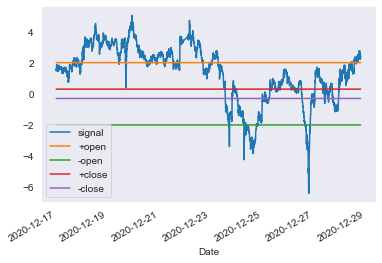

In [27]:
sns.set_style('dark')
all_sample_signal_df.plot()

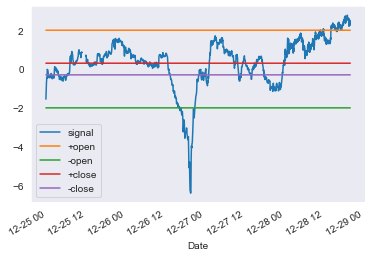

In [28]:
in_sample_signal_df.plot()

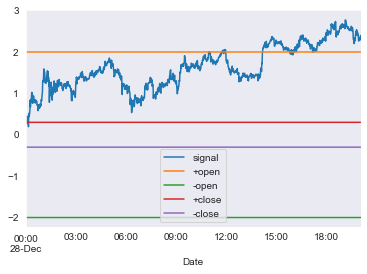

In [29]:
signal_df.plot()

In [30]:
# 종목 수량 계산
print('pair_1 가격 : '  + str(future_close[pair_1][-1]) )
print('pair_2 가격 : '  + str(future_close[pair_2][-1]) )

pair1_shares = 1
pair2_shares = 1 * beta
if signal_df['signal'][-1] > 0:
    print('{}'.format(pair_1) + ' {}'.format(pair1_shares) + ' size 매도 ' \
          + '{} '.format(pair_2)+ '{}'.format(pair2_shares) + ' size 매수 ')

else : 
    print('{}'.format(pair_1) + ' {}'.format(pair1_shares) + ' size 매수 ' \
          + '{} '.format(pair_2)+ '{}'.format(pair2_shares) + ' size 매도 ')

pair_1 가격 : 0.8578
pair_2 가격 : 0.8454
RLCUSDT 1 size 매도 CTKUSDT 0.7378294059935899 size 매수 


In [31]:
future_close[pair_1]

Date
2020-12-16 00:00:00    0.9504
2020-12-16 00:01:00    0.9504
2020-12-16 00:02:00    0.9516
2020-12-16 00:03:00    0.9573
2020-12-16 00:04:00    0.9580
                        ...  
2020-12-28 19:57:00    0.8560
2020-12-28 19:58:00    0.8563
2020-12-28 19:59:00    0.8563
2020-12-28 20:00:00    0.8563
2020-12-28 20:01:00    0.8578
Name: RLCUSDT, Length: 18191, dtype: float64

In [32]:
future_close[pair_2]

Date
2020-12-16 00:00:00    0.9818
2020-12-16 00:01:00    0.9812
2020-12-16 00:02:00    0.9802
2020-12-16 00:03:00    0.9829
2020-12-16 00:04:00    0.9850
                        ...  
2020-12-28 19:57:00    0.8458
2020-12-28 19:58:00    0.8459
2020-12-28 19:59:00    0.8476
2020-12-28 20:00:00    0.8449
2020-12-28 20:01:00    0.8454
Name: CTKUSDT, Length: 18191, dtype: float64

In [34]:
"""
1. 결국 pair1 몇개를 매수하고 pair2 몇개를 매도해야하는가
ex) ln(A) = 2(hedge ratio) * ln(B)
stock B가 1% 오를 때 stock A가 2% 올라간다는 뜻 
따라서 market neutral하게 만들려면 stock B에 2배를 투자해야함
dollar amount에서 보면 10$를 투자한다고했을때,
주식 A amount = 10$ / (주식 A의 가격)
주식 B amount = 20$  / (주식 B의 가격)

2. 매수 매도 판단
ex) 현대 - beta * 기아
spread > 0 일 때, 현대차 매도 기아차 매수 (현대차 고평가, 기아차 저평가)
spread < 0 일 때, 현대차 매수 기아차 매도 (현대차 저평가, 기아차 고평가)
"""

'\n1. 결국 pair1 몇개를 매수하고 pair2 몇개를 매도해야하는가\nex) ln(A) = 2(hedge ratio) * ln(B)\nstock B가 1% 오를 때 stock A가 2% 올라간다는 뜻 \n따라서 market neutral하게 만들려면 stock B에 2배를 투자해야함\ndollar amount에서 보면 10$를 투자한다고했을때,\n주식 A amount = 10$ / (주식 A의 가격)\n주식 B amount = 20$  / (주식 B의 가격)\n\n2. 매수 매도 판단\nex) 현대 - beta * 기아\nspread > 0 일 때, 현대차 매도 기아차 매수 (현대차 고평가, 기아차 저평가)\nspread < 0 일 때, 현대차 매수 기아차 매도 (현대차 저평가, 기아차 고평가)\n'